# Logs analysis - exploratory data analysis

# Setup 

In [64]:
# Data wrangling - Spark
from pyspark.sql.functions import to_date, udf, col, asc, desc, regexp_extract, regexp_replace, to_date
from pyspark.sql.types import IntegerType, TimestampType, BooleanType
from pyspark.sql import functions as F
from pyspark.sql import SparkSession


# Data wrangling - Python
import pandas as pd
import re
import numpy as np

# Sys
import gc
import os
from pathlib import Path
import datetime as dt
import pytz
import shutil

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
ROOT_PATH = Path("..")
file_path = ROOT_PATH /"data"/"processed"/"featurized_logs"

In [8]:
spark

In [9]:
df = spark.read.parquet(file_path.__str__())

# General overview

In [10]:
df.printSchema()
n,p = df.count(), len(df.columns)
print(f"Dataset size: {n} rows and {p} column")

root
 |-- ip_address: string (nullable = true)
 |-- request: string (nullable = true)
 |-- status_code: string (nullable = true)
 |-- size: integer (nullable = true)
 |-- referer: string (nullable = true)
 |-- user_agent: string (nullable = true)
 |-- datetime_utc: timestamp (nullable = true)
 |-- request_method: string (nullable = true)
 |-- request_uri: string (nullable = true)
 |-- http_version: string (nullable = true)
 |-- request_file: string (nullable = true)
 |-- browser_family: string (nullable = true)
 |-- browser_version_string: string (nullable = true)
 |-- os_family: string (nullable = true)
 |-- os_version_string: string (nullable = true)
 |-- device_family: string (nullable = true)
 |-- device_brand: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- is_mobile: boolean (nullable = true)
 |-- is_tablet: boolean (nullable = true)
 |-- is_touch_capable: boolean (nullable = true)
 |-- is_pc: boolean (nullable = true)
 |-- is_ua_bot: boolean (nullable =

In [106]:
# requests time series
request_ts = df.\
                select("datetime_utc", "request", to_date(col("datetime_utc")).alias("date")).\
                sort(asc("date")).\
                groupBy("date").\
                count().\
                withColumnRenamed("count","n_request").\
                toPandas()
y = pd.Series(request_ts.n_request.values, request_ts.date.values)

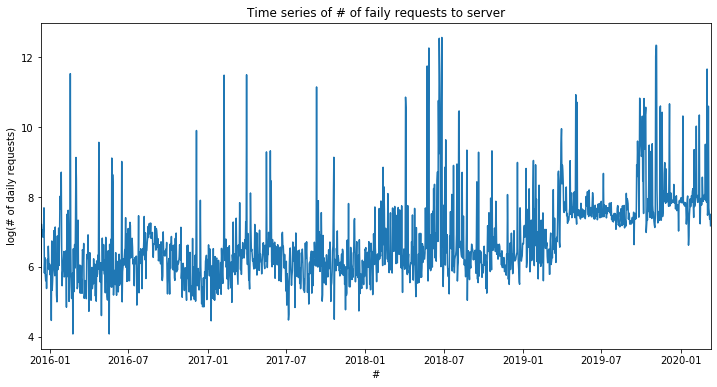

In [110]:
plt.figure(figsize=(12,6))
np.log(y).plot()
plt.title("Time series of # of faily requests to server")
plt.xlabel("#")
plt.ylabel("log(# of daily requests)")
plt.show()

Finally, we can start to see the big picture. The analyzed data set is ranging from the of 2015 up until 10/03/2020, date of my download of the log file. It exihibits an upward trand with important noise. Aggregating log data at this level can be useful to detect massive attacks on server especially 2018-07.

Let's aggrgate data on clients and check the distribution of number of requests per client.

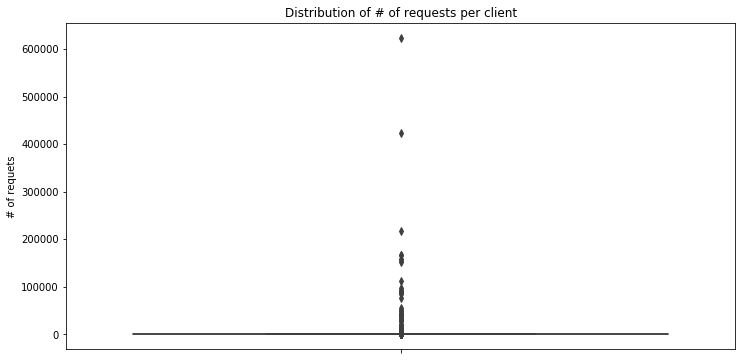

In [146]:
# client toal number of requests
clients = df.\
           select("client_id", "request_id").\
           groupBy("client_id").\
           count().\
           withColumnRenamed("count","n_request").\
           toPandas()

plt.figure(figsize=(12,6))
sns.boxplot(y=clients.n_request.values)
plt.title("Distribution of # of requests per client")
plt.ylabel("# of requets")
plt.show()

It looks loike some clients are requesting (? attacking) the server relentessly !!! These top clients are most probably bots.

In [150]:
top_clients = clients.sort_values(by= "n_request",ascending=False).head()
top_clients

,client_id,n_request
37819,60130146985,623829
56468,60130203301,422999
43286,25770507371,218529
12140,42949820714,167812
101905,34360149441,166722


In [182]:
top_clients.n_request.sum()

1599891

In [183]:
s = top_clients.client_id.values.tolist()
top_bots = df.\
            filter(df.client_id.isin(s)).\
            select("client_id", "ip_address", "user_agent", "referer", "is_ua_bot").\
            dropDuplicates()

sample = sc.parallelize(top_bots.collect()).toDF().toPandas()
sample

,client_id,ip_address,user_agent,referer,is_ua_bot
0,60130203301,193.106.31.130,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,None,False
1,60130146985,13.84.43.203,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,None,False
2,42949820714,198.50.156.189,None,None,False
3,25770507371,100.1.14.108,Python/3.7 aiohttp/3.6.1,None,False
4,34360149441,5.112.235.245,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:1...,http://www.almhuette-raith.at/apache-log/,False


__This simple aggregation uncovered the top 5 most malicious bots that are accouting for 1.6 Million requests !!!!__

This is very promising and powerful and we can do much more :)

## R1: requested file

In [11]:
data = df.\
    groupBy("request_file").\
    count().\
    sort(desc("count")).\
    withColumnRenamed("count","freq").\
    head(10)
data = sc.parallelize(data).toDF().toPandas()

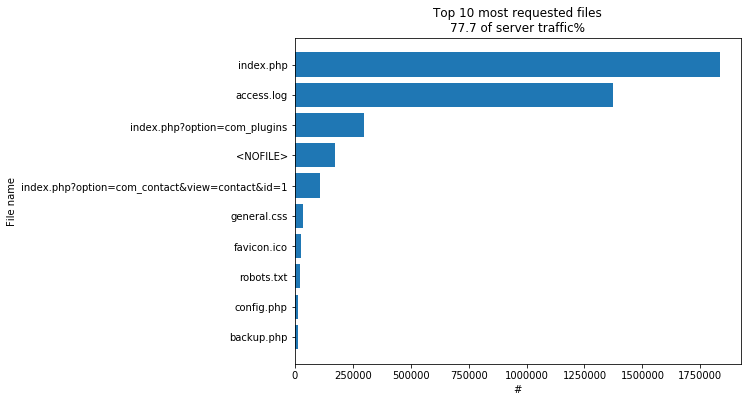

In [12]:
plt.figure(figsize=(8,6))
data.request_file = data.request_file.astype(str)
data = data.sort_values(by="freq", ascending=True)
traffic_fraction = np.round(100*data.freq.sum() / n,1)
plt.barh(y = data.request_file.values, width=data.freq.values)
plt.title(f"Top 10 most requested files\n{traffic_fraction} of server traffic%")
plt.xlabel("#")
plt.ylabel("File name")
plt.show()

## R2: self-declared bot in user agent

In [13]:
data = df.\
    groupBy("is_ua_bot").\
    count().\
    sort(desc("count")).\
    withColumnRenamed("count","freq").\
    head(10)
data = sc.parallelize(data).toDF().toPandas()

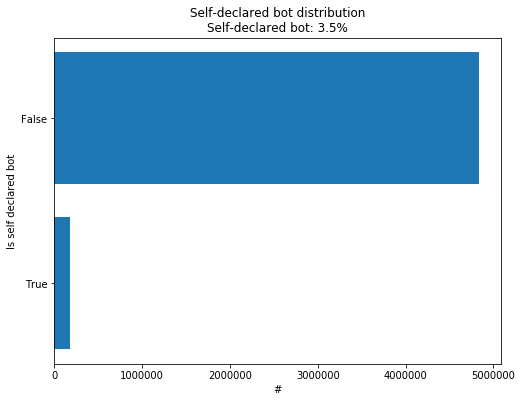

In [14]:
plt.figure(figsize=(8,6))
data.is_ua_bot = data.is_ua_bot.astype(str)
data = data.sort_values(by="freq", ascending=True)
self_bot_fraction = np.round(100*int(data.query("is_ua_bot == 'True'")["freq"])/ n,1)
plt.barh(y = data.is_ua_bot.values, width=data.freq.values)
plt.title(f"Self-declared bot distribution\nSelf-declared bot: {self_bot_fraction}%")
plt.xlabel("#")
plt.ylabel("Is self declared bot")
plt.show()

## R3: HTTP method head

In [15]:
data = df.\
    groupBy("request_method").\
    count().\
    sort(asc("count")).\
    withColumnRenamed("count","freq").\
    toPandas()

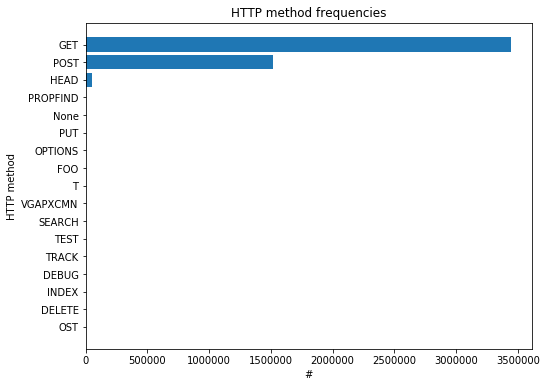

In [16]:
plt.figure(figsize=(8,6))
data.request_method = data.request_method.astype(str)
plt.barh(y = data.request_method.values, width=data.freq.values)
plt.title("HTTP method frequencies")
plt.xlabel("#")
plt.ylabel("HTTP method")
plt.show()

__Comment__

Almost 99% of server traffic is generated by GET, POST and HEAD requests as following
- GET 60.8%
- POST 25,2%
- HEAD 12,4%

Let's examine some HEAD requests. These results are not obvious to conclude that these request are from a bot.

In [17]:
sample = df.\
    select("user_agent", "request","request_method", "is_ua_bot").\
    filter(col("request_method") == "HEAD")
sample = sc.parallelize(sample.take(10)).toDF().toPandas()
sample

,user_agent,request,request_method,is_ua_bot
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,HEAD / HTTP/1.1,HEAD,False
1,Microsoft Office Word 2013,HEAD / HTTP/1.1,HEAD,False
2,Microsoft Office PowerPoint 2014,HEAD /apache-log/access.log HTTP/1.1,HEAD,False
3,Microsoft Office PowerPoint 2014,HEAD /apache-log/access.log HTTP/1.1,HEAD,False
4,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6...,HEAD / HTTP/1.1,HEAD,False
5,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,HEAD /includes/configure.php~ HTTP/1.1,HEAD,False
6,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,HEAD /includes/configure.php_old HTTP/1.1,HEAD,False
7,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,HEAD /includes/configure.php_bak HTTP/1.1,HEAD,False
8,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,HEAD /includes/configure.php.save HTTP/1.1,HEAD,False
9,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,HEAD /includes/configure.php.org HTTP/1.1,HEAD,False


## R4: Requests status code

In [18]:
data = df.\
    groupBy("status_code").\
    count().\
    sort(desc("count")).\
    withColumnRenamed("count","freq").\
    toPandas()

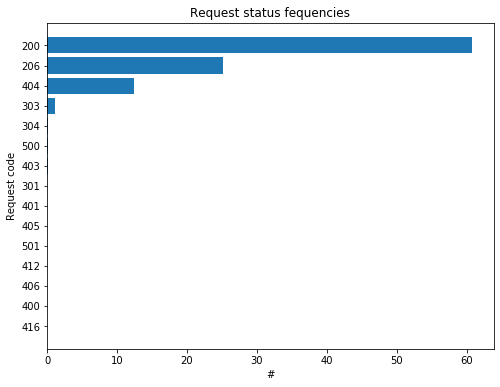

In [19]:
plt.figure(figsize=(8,6))
data.freq = (100/n)*data.freq
data.status_code = data.status_code.astype(str)
data = data.sort_values(by="freq", ascending=True)
plt.barh(y = data.status_code.values, width=data.freq.values)
plt.title("Request status fequencies")
plt.xlabel("#")
plt.ylabel("Request code")
plt.show()

__Comments__


These informations are available here: https://httpstatuses.com/


- 2XX correspond to HTTP request success (~87% of server requests)
    - 200: OK. HTTP calls with 200 status code correspond to successful call.
    - 206: HTTP calls with 206 status code correspond to successful partial retreiving of the content
- 3XX correspond to redirection
    - 303: SEE OTHERS. The server is redirecting the user agent to a different resource, as indicated by a URI in the Location header field, which is intended to provide an indirect response to the original request.
    
- 4XX client errors (~12% of server requests)
    - 404: NOT FOUND. HTTP calls with 404 correspond to not found resource in the server. According to Chio and Freeman, it might be correlated to bot activity caused by an oudated bot script that did not yet adapt to serve update.
    
    
Let's examine some 404 requests.

In [20]:
sample = df.\
    select("user_agent", "request","status_code", "is_ua_bot").\
    filter(col("status_code") == "404")
sample = sc.parallelize(sample.take(10)).toDF().toPandas()
sample

,user_agent,request,status_code,is_ua_bot
0,Opera/9.80 (Windows NT 6.2; Win64; x64) Presto...,GET /wp-login.php HTTP/1.1,404,False
1,Opera/9.80 (Windows NT 6.2; Win64; x64) Presto...,GET /wp-login.php HTTP/1.1,404,False
2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,GET /templates/_system/css/general.css HTTP/1.1,404,False
3,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,GET /templates/_system/css/general.css HTTP/1.1,404,False
4,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,GET /favicon.ico HTTP/1.1,404,False
5,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,GET /templates/_system/css/general.css HTTP/1.1,404,False
6,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,GET /templates/_system/css/general.css HTTP/1.1,404,False
7,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,GET /templates/_system/css/general.css HTTP/1.1,404,False
8,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,GET /templates/_system/css/general.css HTTP/1.1,404,False
9,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,GET /templates/_system/css/general.css HTTP/1.1,404,False


## R5: Request from command line

In [21]:
data = df.\
    groupBy("is_cmd").\
    count().\
    sort(desc("count")).\
    withColumnRenamed("count","freq").\
    toPandas()

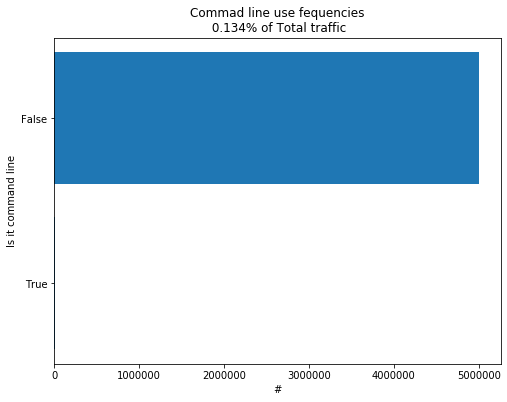

In [22]:
plt.figure(figsize=(8,6))
data.is_cmd = data.is_cmd.astype(str)
freq = data[data.is_cmd == 'True'].iloc[0,1]
fraction = np.round(100.0*freq/n,3)
data = data.sort_values(by="freq", ascending=True)
plt.barh(y = data.is_cmd.values, width=data.freq.values)
plt.title(f"Commad line use fequencies\n {fraction}% of Total traffic")
plt.xlabel("#")
plt.ylabel("Is it command line")
plt.show()

__Comment__

Running a script from command line is highly correlated with bot activity but is a very rare case 0.13% of total traffic.

## R6: SQL injections

In [45]:
data = df.\
    groupBy("is_sql_cmd").\
    count().\
    sort(desc("count")).\
    withColumnRenamed("count","freq").\
    toPandas()

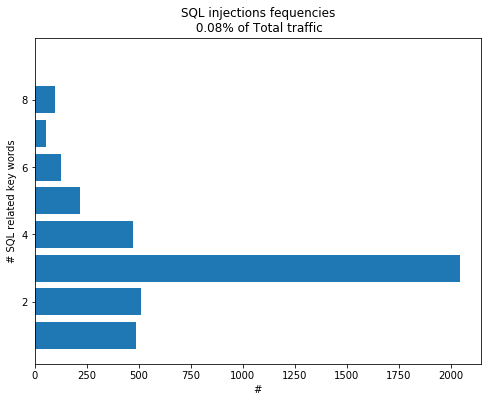

In [47]:
plt.figure(figsize=(8,6))
freq = data[data.is_sql_cmd >0].freq.sum()
fraction = np.round(100.0*freq/n,2)
data = data.sort_values(by="freq", ascending=True)
data = data[data.is_sql_cmd >0]
plt.barh(y = data.is_sql_cmd.values, width=data.freq.values)
plt.title(f"SQL injections fequencies\n {fraction}% of Total traffic")
plt.xlabel("#")
plt.ylabel("# SQL related key words")
plt.show()

__Comment__
Running an SQL injection attack is an advanced bot behavior that is very rare in this web server <= 0.08% of total traffic but highly correlated with malicious bot attack and can be extremley harmful (ex. stuffing user personal data or credentials,...).

In [49]:
sample = df.\
    select("user_agent", "request","is_sql_cmd", "is_ua_bot").\
    filter(col("is_sql_cmd") >= 5)
sample = sc.parallelize(sample.take(10)).toDF().toPandas()
sample

,user_agent,request,is_sql_cmd,is_ua_bot
0,None,GET /index.php?option=com_contactformmaker&vie...,6,False
1,Python/3.7 aiohttp/3.6.1,GET /index.php?option=com_phocagallery&view=ca...,5,False
2,Python/3.7 aiohttp/3.6.1,GET /index.php?option=com_phocagallery&view=ca...,5,False
3,Python/3.7 aiohttp/3.6.1,GET /index.php?option=com_phocagallery&view=ca...,5,False
4,Python/3.7 aiohttp/3.6.1,GET /index.php?option=com_phocagallery&view=ca...,5,False
5,Python/3.7 aiohttp/3.6.1,GET /index.php?option=com_phocagallery&view=ca...,5,False
6,Python/3.7 aiohttp/3.6.1,GET /index.php?option=com_phocagallery&view=ca...,5,False
7,Python/3.7 aiohttp/3.6.1,GET /index.php?option=com_phocagallery&view=ca...,5,False
8,Python/3.7 aiohttp/3.6.1,GET /index.php?option=com_phocagallery&view=ca...,5,False
9,Python/3.7 aiohttp/3.6.1,GET /index.php?option=com_phocagallery&view=ca...,5,False


In [54]:
sample.request[9]

"GET /index.php?option=com_phocagallery&view=category&id=1&Itemid=53&YEyU%3D4842%20AND%201%3D1%20UNION%20ALL%20SELECT%201,NULL,'%3Cscript%3Ealert(%22XSS%22)%3C/script%3E',table_name%20FROM%20information_schema.tables%20WHERE%202%3E1--/**/%3B%20EXEC%20xp_cmdshell('cat%20../../../etc/passwd')%23 HTTP/1.1"

# Data annotation

In [185]:
labeled_df = df.\
                withColumn("is_trivial_bot",
                                (col("request_file") == "robots.txt")|
                                (col("is_ua_bot") == True)|
                                (col("status_code") == "404")|
                                (col("is_cmd") == True)|
                                (col("is_sql_cmd") >= 2))
                                

In [187]:
labeled_df.select("is_trivial_bot").groupBy("is_trivial_bot").count().show()

+--------------+-------+
|is_trivial_bot|  count|
+--------------+-------+
|          true| 757180|
|         false|4258626|
+--------------+-------+



With these simple request-based rules, we can identify 757K bots. Let's see now if we can combine request based and client based detection

# Saving to parquet file

In [188]:
file_path = (ROOT_PATH / "data" / "processed" /"labeled_df").__str__()
labeled_df.write.mode("overwrite").parquet(file_path)